this notebook shows how we transform ANN 5 from keras to pytorch

In [3]:
import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda,Dropout
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

define some hyperparameter 

In [4]:
original_dim_input=109  # CBRAIN input node size

original_dim_output=int(112) # CBRAIN output node size 


input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 323

batch_size= 10740





In [5]:
# load keras model
ANN_5=ke.models.load_model('real_geography/ANNs/ANNs_lin/ANN_5/ANN_5_CRM_lin_model.h5')
ANN_5.summary()
ANN_5_weights=ANN_5.get_weights()



Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 dense (Dense)               (None, 323)               35530     
                                                                 
 dense_1 (Dense)             (None, 323)               104652    
                                                                 
 dense_2 (Dense)             (None, 323)               104652    
                                                                 
 dense_3 (Dense)             (None, 323)               104652    
                                                                 
 dense_4 (Dense)             (None, 112)               36288     
                                                                 
 dense_5 (Dense)             (None, 112)               12656   

2023-06-29 13:52:54.041543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


import pytorch 

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# construct ANN 5 in pytorch 

class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.X_1=nn.Linear(109,323)
        self.X_2=nn.Linear(323,323)
        self.X_3=nn.Linear(323,323)
        self.X_4=nn.Linear(323,323)
        self.X_5=nn.Linear(323,112)
        self.X_6=nn.Linear(112,112)

    def forward(self,x):
        x=F.elu_(self.X_1(x))
        x=F.elu_(self.X_2(x))
        x=F.elu_(self.X_3(x))
        x=F.elu_(self.X_4(x))
        x=F.elu_(self.X_5(x))
        x=self.X_6(x)

        
        return x
    
    
        



        


In [13]:
# initialize ANN 5 in pytorch  
ANN_5_torch=ANN()
print(ANN_5_torch)

ANN(
  (X_1): Linear(in_features=109, out_features=323, bias=True)
  (X_2): Linear(in_features=323, out_features=323, bias=True)
  (X_3): Linear(in_features=323, out_features=323, bias=True)
  (X_4): Linear(in_features=323, out_features=323, bias=True)
  (X_5): Linear(in_features=323, out_features=112, bias=True)
  (X_6): Linear(in_features=112, out_features=112, bias=True)
)


load keras weights and biases into pytorch model 

In [14]:
ANN_5_torch.X_1.weight.data=to.from_numpy(np.transpose(ANN_5_weights[0]))
ANN_5_torch.X_1.bias.data=to.from_numpy(np.transpose(ANN_5_weights[1]))
ANN_5_torch.X_2.weight.data=to.from_numpy(np.transpose(ANN_5_weights[2]))
ANN_5_torch.X_2.bias.data=to.from_numpy(np.transpose(ANN_5_weights[3]))
ANN_5_torch.X_3.weight.data=to.from_numpy(np.transpose(ANN_5_weights[4]))
ANN_5_torch.X_3.bias.data=to.from_numpy(np.transpose(ANN_5_weights[5]))
ANN_5_torch.X_4.weight.data=to.from_numpy(np.transpose(ANN_5_weights[6]))
ANN_5_torch.X_4.bias.data=to.from_numpy(np.transpose(ANN_5_weights[7]))
ANN_5_torch.X_5.weight.data=to.from_numpy(np.transpose(ANN_5_weights[8]))
ANN_5_torch.X_5.bias.data=to.from_numpy(np.transpose(ANN_5_weights[9]))
ANN_5_torch.X_6.weight.data=to.from_numpy(np.transpose(ANN_5_weights[10]))
ANN_5_torch.X_6.bias.data=to.from_numpy(np.transpose(ANN_5_weights[11]))


In [15]:
#define input and out put variables 

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 2 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the ANN training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}






# load vertical axis in pressure coords 
from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load test data set 

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [16]:
from cbrain.save_weights import save_norm

In [17]:
# predict with keras and pytorch model 

In [18]:
pred_keras= ANN_5.predict(val_gen_II[300][0])

432/432 [==============================] - 0s 844us/step


In [19]:
print(pred_keras.shape)
pred_keras

(13824, 112)


array([[ 1.08793756e-08, -1.79497874e-08, -6.37082849e-08, ...,
         5.77678502e-01,  1.82987952e+00,  1.04007494e+00],
       [ 1.10612746e-08, -1.82481017e-08, -6.47996785e-08, ...,
         5.77851713e-01,  1.82926762e+00,  1.04007506e+00],
       [ 1.10576366e-08, -1.82481017e-08, -6.47705747e-08, ...,
         5.77851832e-01,  1.82928097e+00,  1.04007745e+00],
       ...,
       [-2.81579560e-09,  4.66388883e-09,  1.99070200e-08, ...,
         1.42900385e-02, -4.63722646e-03, -3.05929780e-03],
       [-2.81397661e-09,  4.66752681e-09,  1.98924681e-08, ...,
         1.42912045e-02, -4.63765860e-03, -3.06056440e-03],
       [-2.93584890e-09,  4.86033969e-09,  2.06200639e-08, ...,
         1.42704025e-02, -4.64034081e-03, -3.06673348e-03]], dtype=float32)

In [20]:
pred_pytorch=ANN_5_torch(to.from_numpy(val_gen_II[300][0]))

In [21]:
pred_pytorch

tensor([[ 1.0879e-08, -1.7950e-08, -6.3708e-08,  ...,  5.7768e-01,
          1.8299e+00,  1.0401e+00],
        [ 1.1061e-08, -1.8248e-08, -6.4800e-08,  ...,  5.7785e-01,
          1.8293e+00,  1.0401e+00],
        [ 1.1058e-08, -1.8248e-08, -6.4771e-08,  ...,  5.7785e-01,
          1.8293e+00,  1.0401e+00],
        ...,
        [-2.8176e-09,  4.6639e-09,  1.9907e-08,  ...,  1.4290e-02,
         -4.6372e-03, -3.0592e-03],
        [-2.8103e-09,  4.6530e-09,  1.9878e-08,  ...,  1.4291e-02,
         -4.6376e-03, -3.0605e-03],
        [-2.9377e-09,  4.8567e-09,  2.0620e-08,  ...,  1.4270e-02,
         -4.6403e-03, -3.0669e-03]], grad_fn=<AddmmBackward0>)

In [22]:
# get weights and bias 
module = to.jit.trace(ANN_5_torch.forward, to.from_numpy(val_gen_II[300][0]))

In [23]:
# get entire model 
mod = to.jit.trace(ANN_5_torch, to.from_numpy(val_gen_II[300][0]))

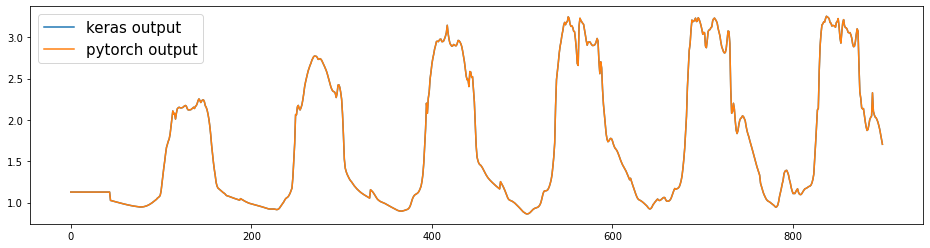

In [24]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

In [25]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=2E-6)

In [26]:
a.shape

(13824, 112)

In [27]:
np.where(a==False)[0].size

81

In [28]:
np.where(a==True)[0].size

1548207

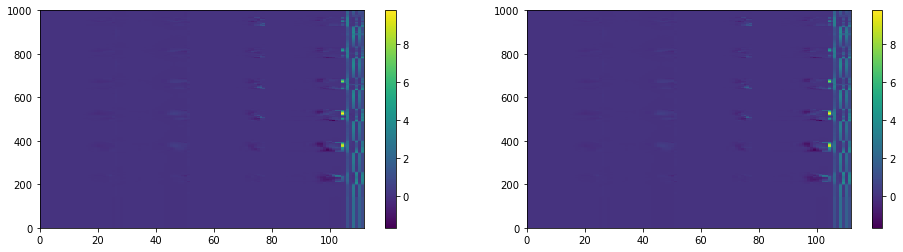

In [29]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])
plt.colorbar()

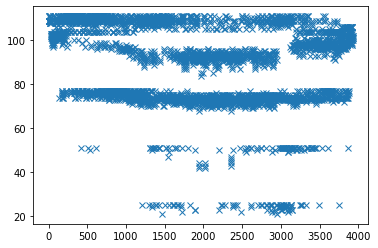

In [30]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-6)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [31]:
#save weights and biases 
to.save(ANN_5_torch,'real_geography/ANNs/ANN_5/ANN_5_CRM_lin.pt')

In [32]:
# saved entire ANN 5
to.jit.save(mod,'real_geography/ANNs/ANN_5/ANN_5_CRM_lin_jit.pt')